In [1]:
# the purpose of this notebook is to finally get to using random forest classification (and maybe other
# machine learning tools depending on what is found) to see if the altitude of a consumer drone can be determined
# by nothing but its struggle to stay upright against different wind (near-ground, in shear-zone, and laminar)

In [153]:
# ================= CONFIGURATION =================
# These are the EXACT columns the model will be trained on and expect during validation.
MODEL_FEATURES = [
    'speed_avg', 
    'speed_sd', 
    'zSpeed_sd', 
    'yaw_sd',          
    'power_avg', 
    'power_sd', 
    'power_intensity', 
    'tilt_avg', 
    'tilt_sd', 
    'turbulence_intensity'
]
# =================================================

In [151]:
# import tings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import plot_tree

In [152]:
df = pd.read_csv('windowed_data.csv')
test_df = "RawFlightLogs/Raw_Jan13.5-33.csv"
train_df = df[~df['file_name'].str.contains('Jan13.5')] # we're gonna test the train_df on the Jan13.5 logs now

In [154]:
X = df[MODEL_FEATURES]
Y = df['altitude(m)'].astype(str)

In [5]:
# splitting X and Y into testing and training, unnecessary for now since i manually separated train_df from the Jan13.5 logs I'll test them on
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67, stratify=y)

In [155]:

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=67)
rf.fit(X, Y)
#Y_hat = rf.predict(X_test)

RandomForestClassifier(max_depth=10, random_state=67)

In [7]:
#rf.score(X_test, Y_test)

NameError: name 'X_test' is not defined

In [67]:
# confusion matrix to determine where the model is going wrong vs right

Y_test_str = Y_test.astype(str)
Y_hat_str = Y_hat.astype(str)
cm = confusion_matrix(Y_test_str, Y_hat_str, labels=['10', '30', '50'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['10m (Ground)', '30m (Shear)', '50m (Laminar)'],
            yticklabels=['10m (Ground)', '30m (Shear)', '50m (Laminar)'])
plt.xlabel('Model Prediction')
plt.ylabel('Actual Altitude')
plt.title('Confusion Matrix: The Blind Altimeter')
plt.show()

NameError: name 'Y_test' is not defined

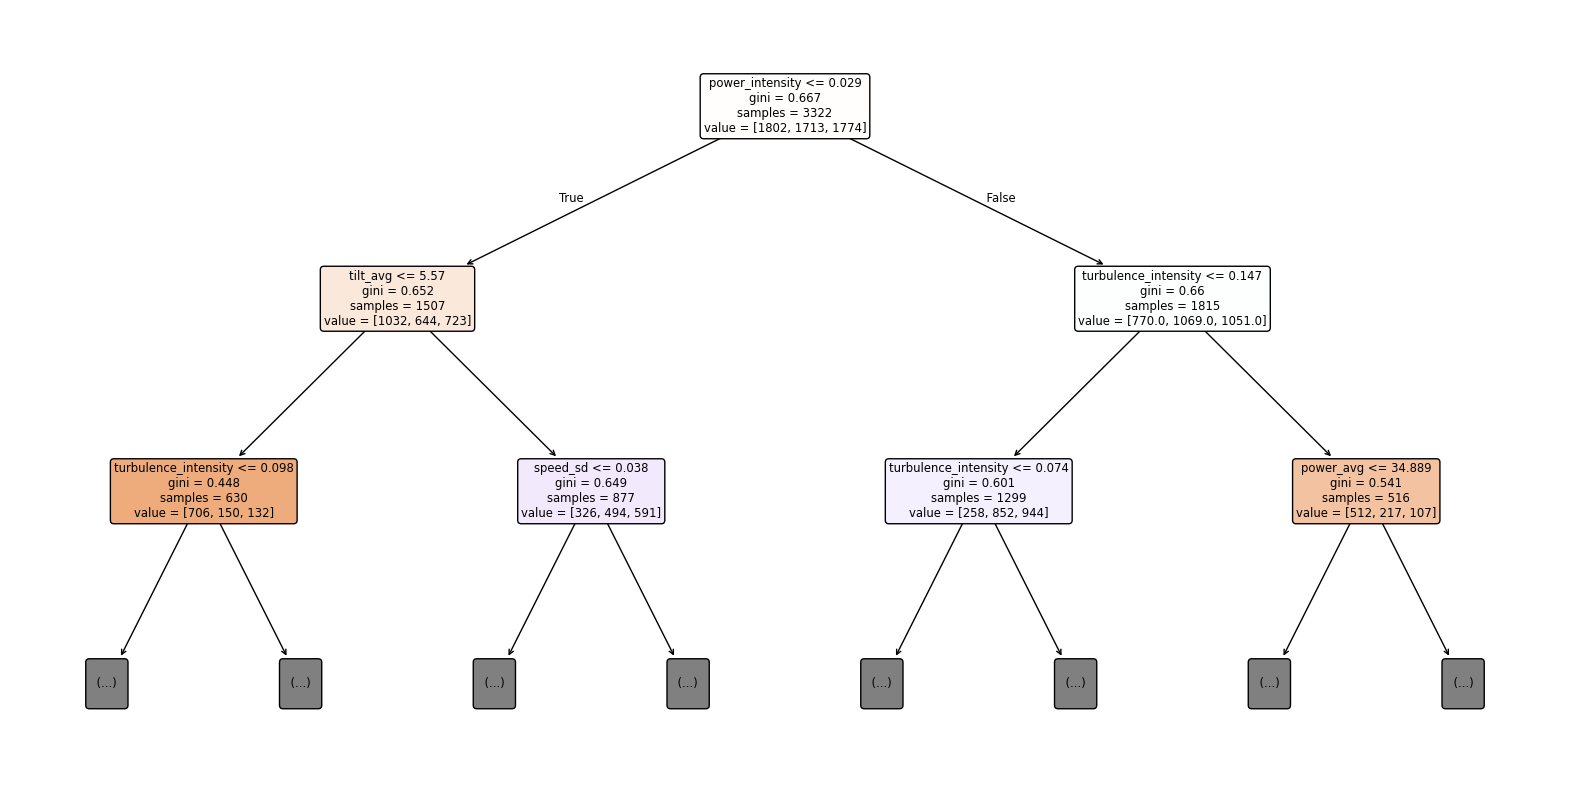

In [156]:
# plot tree, cool to see but no real analysis to collect from it

plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], 
          feature_names=X_train.columns, 
          filled=True, 
          rounded=True, 
          max_depth=2) # Limiting depth for readability
plt.show()

In [117]:
features = pd.DataFrame(rf.feature_importances_, index = X_train.columns).sort_values(by = 0, ascending=False)
features

,0
tilt_avg,0.247021
turbulence_intensity,0.216518
power_avg,0.121212
yaw_sd,0.092840
tilt_sd,0.070508
zSpeed_sd,0.060314
power_sd,0.059838
power_intensity,0.055270
speed_sd,0.039317
speed_avg,0.037162


In [157]:
# Takes a 5-second window of raw data and returns the exact feature dictionary  needed for the Random Forest.
# same function as in AggregateLogs.ipynb

def extract_features(window):
    # 1. Vector Yaw (The Fix)
    # Handles the 0/360 degree wrap-around bug
    compass_rads = np.radians(window['compass_heading(degrees)'])
    yaw_sd = np.sqrt(np.sin(compass_rads).std()**2 + np.cos(compass_rads).std()**2)
    
    # 2. Power Stats
    # Power = Voltage * Current
    power_watts = window['voltage(v)'] * window['current(A)']
    p_mean = power_watts.mean()
    p_std = power_watts.std()
    
    # 3. Tilt Stats
    # Calculate Magnitude if not already present
    if 'tilt_magnitude' not in window.columns:
        tilt_mag = np.sqrt(window['pitch(degrees)']**2 + window['roll(degrees)']**2)
    else:
        tilt_mag = window['tilt_magnitude']
        
    tilt_mean = tilt_mag.mean()
    tilt_std = tilt_mag.std()
    
    # 4. Return the Dictionary (Keys must match CSV columns EXACTLY)
    return {
        'speed_avg': window['speed(mph)'].mean(),
        'speed_sd': window['speed(mph)'].std(),
        'zSpeed_sd': window['zSpeed(mph)'].std(),
        'yaw_sd': yaw_sd,            
        'power_avg': p_mean,
        'power_sd': p_std,
        'power_intensity': p_std / (p_mean + 0.05),
        'tilt_avg': tilt_mean,
        'tilt_sd': tilt_std,
        'turbulence_intensity': tilt_std / (tilt_mean + 0.05)
    }

In [159]:
# this cell handles the validating part of the model. feed it a random file that the model wasn't trained on and see how it performs.
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# ========= BEGIN FUNCTION ============

def validate_model_on_log(filepath, model):

    # read the base file
    flight_df = pd.read_csv(filepath)
    flight_df.columns = flight_df.columns.str.lstrip()

    # making the new columns the raw file doesn't have
    flight_df['tilt_magnitude'] = np.sqrt(flight_df['pitch(degrees)']**2 + flight_df['roll(degrees)']**2)
    flight_df['power(watt)'] = flight_df['voltage(v)'] * flight_df['current(A)']
    flight_df['timestamp'] = flight_df['datetime(utc)']

    # find height
    if 'height_above_takeoff(meters)' in flight_df.columns:
        pass # we good
    elif 'height_above_takeoff(feet)' in flight_df.columns:
        flight_df['height_above_takeoff(meters)'] = flight_df['height_above_takeoff(feet)'] * 0.3048
    else:
        raise KeyError("There's no altitude column. Check your file once more.")

    # ============== sliding window logic is mostly borrowed from AggregateLogs.ipynb ==============

    WINDOW_SIZE = 50
    STEP_SIZE = 5
    windows = []
    
    for i in range(0, len(flight_df) - WINDOW_SIZE, STEP_SIZE):
        window = flight_df.iloc[i:i + WINDOW_SIZE]
    
        # check that user isn't moving (throttling the drone)
        # if there is any throttling in the window, assume it is NOT auto.
        # will have to do something about the drone continuing to move for a second after releasing the throttle... confounds the data a bit
        if 'rc_throttle' in window.columns:
            is_auto = (window['rc_throttle'] == 1024).all() 
        else:
            flight_df = flight_df.copy()
            print("No rc_throttle column found. Assuming full file is auto-flight.")
        
        altitude_avg = window['height_above_takeoff(meters)'].mean()
        
        # track vertical climb or drop speed to see when drone is moving up or down
        zSpeed_avg = window['zSpeed(mph)'].abs().mean()
        is_stable = zSpeed_avg < 0.5

        # only if both of these are true is it valid for prediction
        valid_for_prediction = is_auto and is_stable
        
        # define correct answer but ignore transitory zones
        true_zone = -1
        if 7 <= altitude_avg <= 13:
            true_zone = 10
        elif 27 <= altitude_avg <= 33:
            true_zone = 30
        elif 47 <= altitude_avg <= 53:
            true_zone = 50
            
        stats = extract_features(window)

        # Add metadata for plotting
        stats['timestamp'] = window['timestamp'].iloc[-1]
        stats['true_zone'] = true_zone
        stats['valid_for_prediction'] = valid_for_prediction
        stats['true_altitude_m'] = altitude_avg
        
        windows.append(stats)
        
    validation_df = pd.DataFrame(windows)

    raw_predictions = model.predict(validation_df[MODEL_FEATURES])

    # converts predictions from strings to ints to align with true_zone
    raw_predictions = raw_predictions.astype(int)
    
    # If stable -> Use Model Prediction
    # If unstable -> Set to 0 (or a special code for "Transition")
    validation_df['predicted_zone'] = np.where(validation_df['valid_for_prediction'], raw_predictions, np.nan)
    
    return validation_df

# ============== END FUNCTION ================
# now we run the function and do the real test

val_df = validate_model_on_log(test_df, rf)

valid_windows = val_df.dropna(subset=['predicted_zone'])
valid_windows = valid_windows[valid_windows['true_zone'] != -1] # exists solely to calculate accuracy_score. must be valid for prediction AND be in the 10, 30, 50m range

# getting accuracy and checking that a valid window exists
if not valid_windows.empty:
    acc = accuracy_score(valid_windows['true_zone'], valid_windows['predicted_zone'])
    print(f"\n✅ Accuracy on Stable Auto-Flight Sections: {acc:.1%}")
else:
    print("\n⚠️ No stable auto-flight sections found for accuracy check.")

# ========= PLOT THE RESULT =============
plt.figure(figsize=(14, 6))

# Convert timestamps to elapsed seconds
times = pd.to_datetime(val_df['timestamp'])
elapsed = (times - times.iloc[0]).dt.total_seconds() # new column of seconds elapsed since start
val_df['elapsed_time'] = elapsed # save to df for easy grouping

# plot line that follows altitude throughout
plt.plot(val_df['elapsed_time'], val_df['true_altitude_m'], 
         color='black', alpha=0.3, linewidth=2, label='True Altitude')

# filter for valid predictions
scatter_data = val_df.dropna(subset=['predicted_zone']) # exists for the graph. only needs the data to be valid for prediction (in case drone is at 25m, it would still run a check despite not being in the +- 3m range of the main altitudes)

# plot predictions (the model)
# Green=10m, Orange=30m, Blue=50m
color_map = {10: 'green', 30: 'orange', 50: 'blue'}
pred_colors = [color_map.get(p, 'gray') for p in scatter_data['predicted_zone']]

plt.scatter(scatter_data['elapsed_time'], scatter_data['true_altitude_m'], 
            c=pred_colors, s=30, alpha=0.8, label='Model Prediction')

# titles, labels, all that jazz
plt.title(f"Blind Altimeter Validation: {''.join(test_df.split('/')[1:])}", fontsize=14)
plt.xlabel("Time (Seconds)")
plt.ylabel("Altitude (m)")
plt.grid(True, linestyle='--', alpha=0.5)

# custom Legend
patches = [
    mpatches.Patch(color='green', label='Pred: 10m'),
    mpatches.Patch(color='orange', label='Pred: 30m'),
    mpatches.Patch(color='blue', label='Pred: 50m'),
    Line2D([0], [0], color='black', alpha=0.3, lw=2, label='Actual Altitude')
]
plt.legend(handles=patches, loc='best')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Raw_FlightLogs/Raw_Jan13.5-33.csv'

In [141]:
print(f"Total Windows: {len(val_df)}")
print(f"Auto-Flight Windows (Hands off sticks): {val_df['valid_for_prediction'].sum()}")

# Check why they are failing
# (We need to reconstruct the flags temporarily to check)
throttle_check = val_df['valid_for_prediction'] # This isn't quite right since it's combined
# Let's just look at the flags if you saved them, or infer them:
print("\n--- Diagnostic Guess ---")
if 'is_stable' in val_df.columns:
    print(f"Stable Windows: {val_df['is_stable'].sum()}")

Total Windows: 272
Auto-Flight Windows (Hands off sticks): 122

--- Diagnostic Guess ---
